In [94]:
import numpy as np
import matplotlib.pylab as plt
#from scipy.misc import imresize, imread
from PIL import Image
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
import glob
import os
import shutil
import random

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm import tqdm
import tensorflow.keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
"""
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
"""

%matplotlib inline

In [ ]:
pip install --upgrade tensorflow

In [ ]:
pip install tensorflow==2.0

In [98]:
IMAGE_RESIZE = 50
BATCH_SIZE_TRAINING = 16

### Organiser les images

Réorganiser les fichiers dans 0/1 dosiers et éliminer les dossers numéro patient

In [ ]:
def organize_images(data_path, pre_processed_data_path):
    files = glob.glob(data_path + '\**\*.png', recursive=True)
    class_0_path = os.path.join(pre_processed_data_path,"0")
    class_1_path = os.path.join(pre_processed_data_path,"1")
    os.makedirs(class_0_path,exist_ok=True)
    os.makedirs(class_1_path,exist_ok=True)
    
    for file in files:
        if "class0" in file:
            file_dest = os.path.join(class_0_path,os.path.basename(file))
        elif "class1" in file:  
            file_dest = os.path.join(class_1_path,os.path.basename(file))
        shutil.copyfile(file, file_dest)

organize_images("..\..\data", "..\..\pre_processed_data")

In [ ]:
xx = glob.glob('..\..\data\**\*.png', recursive=True)
print(len(xx))

In [ ]:
"""
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    #for x in unique_list: 
    #    print x,
    return unique_list
"""

# Split dataset to Train and Test data

We will create a method that extracts 20% of the data for the test and the rest will be for the train.

In [30]:
def extract_train_test_data(data_forlder, part_percentage):
    files_0 = glob.glob(data_forlder + '/0/*.png', recursive=True)
    files_1 = glob.glob(data_forlder + '/1/*.png', recursive=True)
    part_files_0_len = int((len(files_0)*part_percentage)/100)
    part_files_1_len = int((len(files_1)*part_percentage)/100)
    
    part_files_0_train = []
    part_files_0_test = []
    
    part_files_1_train = []
    part_files_1_test = []
    for index, file in enumerate(files_0):
        if index < part_files_0_len:
            part_files_0_test.append(os.path.abspath(file))
        else:
            part_files_0_train.append(os.path.abspath(file))
            
    for index, file in enumerate(files_1):
        if index < part_files_1_len:
            part_files_1_test.append(os.path.abspath(file))
        else:
            part_files_1_train.append(os.path.abspath(file))
    
    return part_files_0_train, part_files_1_train, part_files_0_test, part_files_1_test

In [31]:
result = extract_train_test_data("../../pre_processed_data", 20)
part_files_0_train, part_files_1_train, part_files_0_test, part_files_1_test = result
#part_files_0, part_files_1 = resut
#print(len(part_files_0))
#print(len(part_files_1))

In [32]:
def create_data_repos(folder, files_0, files_1):
    #create 
    os.makedirs(folder, exist_ok=True)
    
    class_0_path = os.path.join(folder,"0")
    class_1_path = os.path.join(folder,"1")
    os.makedirs(class_0_path,exist_ok=True)
    os.makedirs(class_1_path,exist_ok=True)
    
    for index, file in enumerate(files_0):
        shutil.copyfile(file, os.path.join(class_0_path,os.path.basename(file)))
    
    for index, file in enumerate(files_1):
        shutil.copyfile(file, os.path.join(class_1_path,os.path.basename(file)))

In [33]:
create_data_repos("../../train_data",part_files_0_train, part_files_1_train )

In [34]:
create_data_repos("../../test_data",part_files_0_test, part_files_1_test )

# Split trainset to labeled trainset and unlabeled trainset

We will take a small portion of the data as labeled training data and then a large portion as unlabeled.

In [35]:
result = extract_train_test_data("../../train_data", 20)
part_files_0_train, part_files_1_train, part_files_0_sub_train, part_files_1_sub_train = result

Creation of labelled data

In [36]:
create_data_repos("../../sub_train_data",part_files_0_sub_train, part_files_1_sub_train)

In [41]:
def create_unlabeled_repos(output_folder,files_0, files_1):
    os.makedirs(output_folder,exist_ok=True)
    all_files = files_0 + files_1
    random.shuffle(all_files)
    for file in all_files:
        shutil.copyfile(file, os.path.join(output_folder,os.path.basename(file)))

In [42]:
create_unlabeled_repos("../../unlabeled_data",part_files_0_train, part_files_1_train)

In [99]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    featurewise_center=True, 
    featurewise_std_normalization=True,
    zca_whitening=True,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
                                "../../sub_train_data/",
                                target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
                                batch_size=BATCH_SIZE_TRAINING,
                                class_mode='categorical',
                                subset='training') # set as training data

"""
validation_generator = train_datagen.flow_from_directory(
                                "train/", # same directory as training data
                                target_size=(IMAGE_RESIZE, IMAGE_RESIZE),
                                batch_size=BATCH_SIZE_VALIDATION,
                                class_mode='categorical',
                                subset='validation') # set as validation data
"""

Found 35523 images belonging to 2 classes.


'\nvalidation_generator = train_datagen.flow_from_directory(\n                                "train/", # same directory as training data\n                                target_size=(IMAGE_RESIZE, IMAGE_RESIZE),\n                                batch_size=BATCH_SIZE_VALIDATION,\n                                class_mode=\'categorical\',\n                                subset=\'validation\') # set as validation data\n'

In [100]:
x_batch, y_batch = next(train_generator)

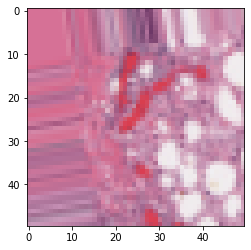

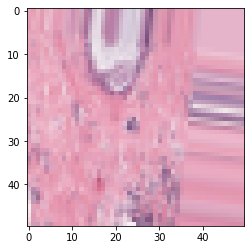

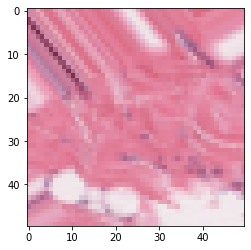

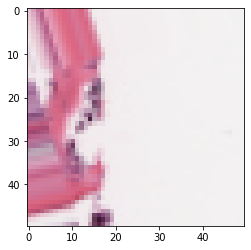

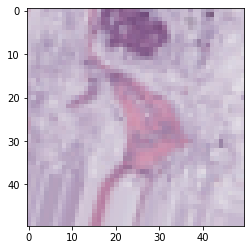

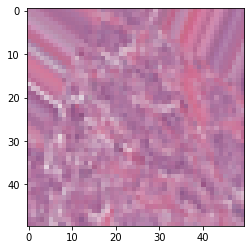

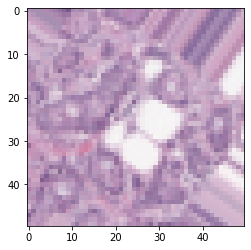

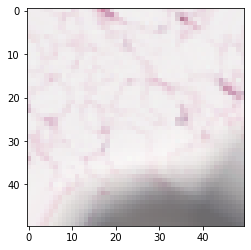

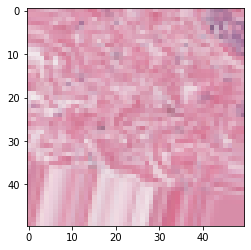

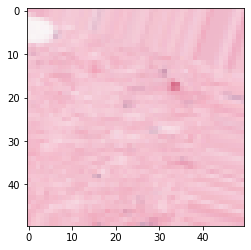

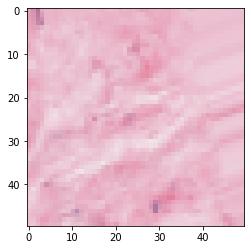

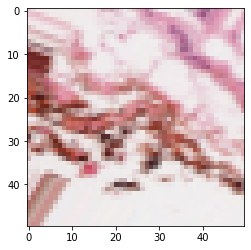

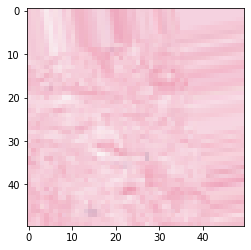

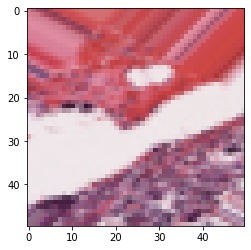

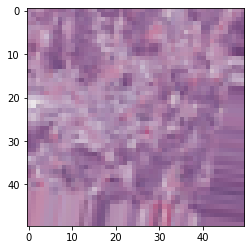

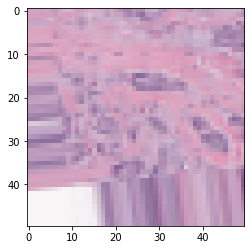

IndexError: index 16 is out of bounds for axis 0 with size 16

In [102]:
for i in range (0,16):
    image = x_batch[i]
    #plt.imshow(image.transpose(2,1,0))
    plt.imshow(image)
    plt.show()

# Create generator algo

In [88]:
# Generator
# Reference: Chapter 20, GANs in Python by Jason Brownlee, Chapter 7 of GANs in Action
def generator_network(latent_dim):
    in_lat = Input(shape=(latent_dim,))

    n_nodes = 256 * 3 * 3
    gen = Dense(n_nodes)(in_lat)
    gen = Reshape((3, 3, 256))(gen)

    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(gen)
    # gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.01)(gen)

    gen = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(gen)
    # gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.01)(gen)
    
    gen = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(gen)
    # gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.01)(gen)
    
    gen = Conv2DTranspose(16, (3,3), strides=(1,1), padding='same')(gen)
    # gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.01)(gen)
    
    gen = Conv2DTranspose(8, (3,3), strides=(2,2), padding='same')(gen)
    # gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.01)(gen)
    
    gen = ZeroPadding2D()(gen)
    
    out_layer = Conv2DTranspose(3, (3,3), strides=(1, 1), activation='tanh', padding='same')(gen)

    model = Model(in_lat, out_layer)

    return model

# Create Discriminator

In [89]:
# Discriminator: Shared weights between the supervised classifier and standard discriminator 
# as found in GANs
# Reference: Chapter 20, GANs in Python by Jason Brownlee, Chapter 7 of GANs in Action

# Activation function for the discriminator as proposed in https://arxiv.org/abs/1606.03498
def custom_activation(output):
    logexpsum = K.sum(K.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result

def disc_network(in_shape=(50,50,3), n_classes=2):
    in_image = Input(shape=in_shape)
 
    fe = Conv2D(32, (3,3), strides=(2,2), padding='same')(in_image)
    fe = LeakyReLU(alpha=0.01)(fe)

    fe = Conv2D(64, (3,3), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.01)(fe)
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = BatchNormalization()(fe)
    fe = LeakyReLU(alpha=0.01)(fe)

    fe = Dropout(0.4)(fe)
    fe = Flatten()(fe)

    fe = Dense(n_classes)(fe)

    # Supervised classifier
    c_out_layer = Activation('softmax')(fe)
    c_model = Model(in_image, c_out_layer)

    # Traditional discriminator as found in GANs
    d_out_layer = Lambda(custom_activation)(fe)
    d_model = Model(in_image, d_out_layer)

    return d_model, c_model

In [86]:
# Generator network
generator = generator_network(latent_dim=128)
generator.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 2304)              297216    
_________________________________________________________________
reshape_12 (Reshape)         (None, 3, 3, 256)         0         
_________________________________________________________________
conv2d_transpose_56 (Conv2DT (None, 6, 6, 128)         295040    
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_transpose_57 (Conv2DT (None, 12, 12, 64)        73792     
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 12, 12, 64)        0  

In [90]:
# Discriminator and classifier
disc_network, classifier = disc_network()
print(disc_network.summary())
print(classifier.summary())

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 50, 50, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 32)        896       
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         738

### Run forward passes

In [ ]:
# Run forward passes
print(classifier(np.expand_dims(X_train_sub[0], 0)).shape)
print(disc_network(np.expand_dims(X_train_sub[0], 0)).shape)
print(generator(np.random.normal(size=(1, 128))).shape)